# **Part 1-Feature Extraction**

**Data PreProcessing**

Task 1

In the first section, I have performed data preprocessing.
1.   Set up the environment, imported libraries, and loaded the dataset.
2.   Checked for null values using isnull from Pandas.
3.   Plotted a box plot to identify outliers, which were subsequently removed with a custom function.
4.  Parsed timestamps for chronological consistency in battery charging and discharging data.

Task 2

In this section I have written an algorithm to calculate the FECs of the battery.
1.  Added "charge status" column to monitor SOC changes
2.  Added "charge current" column to track current differences during charging
3.  Added "cycles" column tallies completed cycles by summing charge statuses and dividing by 100, revealing the total FECs the battery has undergone.



Task 3

In this section Battery capacity has been calculated.

1.   Calculated time differences and charge changes
2.   I estimated battery capacity as an average over ten cycles by considering changes in charge.

# 1- Data PreProcessing

Importing the libraries and dataset

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Read data from an csv file
# from google.colab import drive
# drive.mount('/content/drive')

# file_path = '/content/drive/My Drive/Part1(1).csv'
# df5 = pd.read_csv(file_path)

In [ ]:
!wget -O Part1.csv https://github.com/A-SOLO/LOHUM_PS_file/raw/main/Part1.csv

--2023-11-08 18:31:19--  https://github.com/A-SOLO/LOHUM_PS_file/raw/main/Part1.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/A-SOLO/LOHUM_PS_file/main/Part1.csv [following]
--2023-11-08 18:31:19--  https://raw.githubusercontent.com/A-SOLO/LOHUM_PS_file/main/Part1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2761975 (2.6M) [text/plain]
Saving to: ‘Part1.csv’

Part1.csv           100%[===================>]   2.63M  --.-KB/s    in 0.03s   

2023-11-08 18:31:20 (88.8 MB/s) - ‘Part1.csv’ saved [2761975/2761975]



In [ ]:
df5 = pd.read_csv("/content/Part1.csv")
print(df5.head())

   Unnamed: 0         timestamp  soc  voltage  current
0        2657  01-01-1970 00:00    0      0.0      0.0
1       25801  01-01-1970 00:00    0      0.0      0.0
2       71954  09-11-2021 07:05   59     52.3      0.0
3       71955  09-11-2021 07:05   93     57.3      0.0
4       71956  09-11-2021 07:07   93     56.7     12.8


Finding whether it contains any null values or not

In [ ]:
print(df5.isnull().sum())

Unnamed: 0    0
timestamp     0
soc           0
voltage       0
current       0
dtype: int64


<ipython-input-5-e882fb661be5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df5.corr()


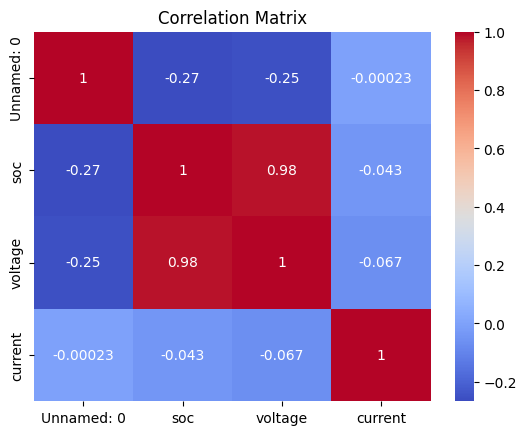

In [ ]:
correlation_matrix = df5.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

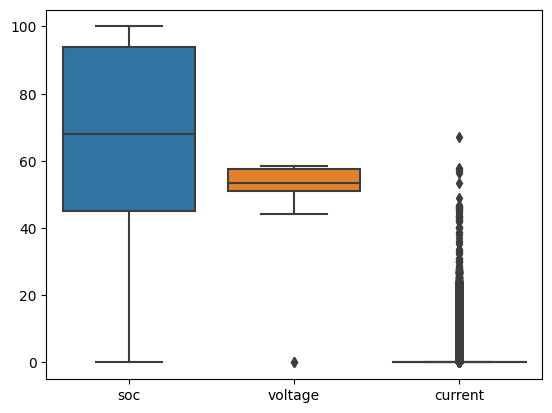

In [ ]:
#box plot to find the outliers
sns.boxplot(data=df5[['soc', 'voltage', 'current']])
plt.show()


In [ ]:
#This function removes the value which lie outside the 25th and 75th percentile of the dataset
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

df5 = remove_outlier(df5, 'soc')
df5 = remove_outlier(df5, 'voltage')
df5

,Unnamed: 0,timestamp,soc,voltage,current
2,71954,09-11-2021 07:05,59,52.3,0.0
3,71955,09-11-2021 07:05,93,57.3,0.0
4,71956,09-11-2021 07:07,93,56.7,12.8
5,71957,09-11-2021 07:07,93,57.1,2.9
6,71958,09-11-2021 07:07,93,57.1,0.0
...,...,...,...,...,...
81135,11957,31-01-2022 17:08,72,54.2,0.0
81136,11958,31-01-2022 17:08,72,54.2,0.0
81137,11959,31-01-2022 17:10,72,54.2,0.0
81138,11960,31-01-2022 17:10,72,54.2,0.0


Parse the time stamps column

In [ ]:
df5['time_parsed'] = pd.to_datetime(df5['timestamp'], format='%d-%m-%Y %H:%M')
df5 = df5.sort_values(by=['time_parsed'])   #Sorting the DataFrame according to the timestamp

# 2- Algorithm to calculate the FECs that the battery has undergone.

Creating a charge_current column which gives the current difference while charging.

In [ ]:
df5['charge_status'] = df5['soc'] - df5['soc'].shift(1)  #Creating a charge status column finds the change in charge.
df5['charge_current']=0

charge_status = -1
for i in range(df5.shape[0]):
  if(df5['charge_status'].iloc[i]!=0):
    charge_status = df5['charge_status'].iloc[i]

  if(charge_status>0):
    df5['charge_current'].iloc[i] = df5['current'].iloc[i]
  else:
    df5['charge_current'].iloc[i] = 0   # Assigning 0 value for the charge_current if the battery is discharging

<ipython-input-9-d79692e91bf5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['charge_current'].iloc[i] = 0   # Assigning 0 value for the charge_current if the battery is discharging
<ipython-input-9-d79692e91bf5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['charge_current'].iloc[i] = df5['current'].iloc[i]


Fraction of cycle completed at each timestep by adding only the positive values of charge_status and then dividing them by 100





In [ ]:
df5['cycles'] = df5['charge_status'].map(lambda x : x if x>0 else 0).cumsum()/100

In [ ]:
df5


,Unnamed: 0,timestamp,soc,voltage,current,time_parsed,charge_status,charge_current,cycles
2,71954,09-11-2021 07:05,59,52.3,0.0,2021-11-09 07:05:00,NaN,0.0,0.00
3,71955,09-11-2021 07:05,93,57.3,0.0,2021-11-09 07:05:00,34.0,0.0,0.34
4,71956,09-11-2021 07:07,93,56.7,12.8,2021-11-09 07:07:00,0.0,12.8,0.34
5,71957,09-11-2021 07:07,93,57.1,2.9,2021-11-09 07:07:00,0.0,2.9,0.34
6,71958,09-11-2021 07:07,93,57.1,0.0,2021-11-09 07:07:00,0.0,0.0,0.34
...,...,...,...,...,...,...,...,...,...
81134,11956,31-01-2022 17:08,72,54.2,0.0,2022-01-31 17:08:00,0.0,0.0,51.81
81136,11958,31-01-2022 17:08,72,54.2,0.0,2022-01-31 17:08:00,0.0,0.0,51.81
81138,11960,31-01-2022 17:10,72,54.2,0.0,2022-01-31 17:10:00,0.0,0.0,51.81
81137,11959,31-01-2022 17:10,72,54.2,0.0,2022-01-31 17:10:00,0.0,0.0,51.81


Total FECs count is given by following code

In [ ]:
int(df5['cycles'].iloc[-1])  #Total FECs count is given by this line

51

#3- Capacity of Battery

Time difference calculation

In [ ]:
df6=df5
df6['time_secs'] = df5['time_parsed'] - df5['time_parsed'].shift(1)
df6['time_secs'] = df6['time_secs'].map(lambda x : (pd.Timedelta(x, unit='h').total_seconds())).fillna(0)

In [ ]:
df5.head(100)

,Unnamed: 0,timestamp,soc,voltage,current,time_parsed,charge_status,charge_current,cycles,time_secs
2,71954,09-11-2021 07:05,59,52.3,0.0,2021-11-09 07:05:00,NaN,0.0,0.00,0.0
3,71955,09-11-2021 07:05,93,57.3,0.0,2021-11-09 07:05:00,34.0,0.0,0.34,0.0
4,71956,09-11-2021 07:07,93,56.7,12.8,2021-11-09 07:07:00,0.0,12.8,0.34,120.0
5,71957,09-11-2021 07:07,93,57.1,2.9,2021-11-09 07:07:00,0.0,2.9,0.34,0.0
6,71958,09-11-2021 07:07,93,57.1,0.0,2021-11-09 07:07:00,0.0,0.0,0.34,0.0
...,...,...,...,...,...,...,...,...,...,...
97,72049,09-11-2021 09:07,73,53.6,0.0,2021-11-09 09:07:00,-1.0,0.0,0.35,120.0
98,72050,09-11-2021 09:09,72,52.8,14.5,2021-11-09 09:09:00,-1.0,0.0,0.35,120.0
100,72052,09-11-2021 09:12,71,53.3,0.0,2021-11-09 09:12:00,-1.0,0.0,0.35,180.0
101,72053,09-11-2021 09:12,71,53.3,0.0,2021-11-09 09:12:00,0.0,0.0,0.35,0.0


Finding the Change of Charge at each timestamp (Q = I*t)

In [ ]:
df6['charge_change'] = df6['charge_current']*(df6['time_secs']/3600)
df6.head(1000)

,Unnamed: 0,timestamp,soc,voltage,current,time_parsed,charge_status,charge_current,cycles,time_secs,charge_change
2,71954,09-11-2021 07:05,59,52.3,0.0,2021-11-09 07:05:00,NaN,0.0,0.00,0.0,0.000000
3,71955,09-11-2021 07:05,93,57.3,0.0,2021-11-09 07:05:00,34.0,0.0,0.34,0.0,0.000000
4,71956,09-11-2021 07:07,93,56.7,12.8,2021-11-09 07:07:00,0.0,12.8,0.34,120.0,0.426667
5,71957,09-11-2021 07:07,93,57.1,2.9,2021-11-09 07:07:00,0.0,2.9,0.34,0.0,0.000000
6,71958,09-11-2021 07:07,93,57.1,0.0,2021-11-09 07:07:00,0.0,0.0,0.34,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
997,20715,11-11-2021 04:57,39,50.5,3.5,2021-11-11 04:57:00,0.0,0.0,1.58,0.0,0.000000
1000,20718,11-11-2021 05:00,38,50.4,3.1,2021-11-11 05:00:00,-1.0,0.0,1.58,180.0,0.000000
999,20717,11-11-2021 05:00,38,50.5,2.1,2021-11-11 05:00:00,0.0,0.0,1.58,0.0,0.000000
998,20716,11-11-2021 05:00,39,50.4,4.4,2021-11-11 05:00:00,1.0,4.4,1.59,0.0,0.000000


Finding where 10th cycle occured

In [ ]:
cycle_10th=0
for i in range(df5.shape[0]):
  if(df6['cycles'].iloc[i]>=10):
    cycle_10th = i
    break

Following expression gives the Capacity of the battery (in Ah)

In [ ]:
# Summing up all the Positive change of charges at all timestamps till the 10th cycle
# and then divide by 10 to obtain the average over 10 cycles

df6.head(cycle_10th)['charge_change'].sum()/10

25.910666666666668



---


# **PART 2 - REGRESSION**


---



**TASK 1:**


*  Imported libraries
*  Dowloaded data
*  Plotted graphs
*  Cleaned data
*  Dropped outliers
*  Trained the Model
*  Extracted actual useful life
*  Created row for SOH in actual file
*  Created function for predicting SOH



**TASK 2:**

*  Calculated the remaining useful life (RUL) for given number of cycle

 1.   RUL at 500th Cycle : 3156
 2.   RUL at 1000th Cycle : 2656
 3.   RUL at 2000th Cycle : 1656
 4.   RUL at 3000th Cycle : 656
 5.   RUL at 3500th Cycle : 156

*  Plotted line chart for Predicted VS Actual

**TASK 3:**

Calculated the performance metrics of the trained model.
> RMSE = 0.00822525864869343


> MAE = 0.006380899855272596

**IMPORTING DATA AND LIBRARIES**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
!wget -O Part2.csv.xlsx https://github.com/A-SOLO/LOHUM_PS_file/raw/main/Part2.csv.xlsx

--2023-11-08 18:33:16--  https://github.com/A-SOLO/LOHUM_PS_file/raw/main/Part2.csv.xlsx
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/A-SOLO/LOHUM_PS_file/main/Part2.csv.xlsx [following]
--2023-11-08 18:33:16--  https://raw.githubusercontent.com/A-SOLO/LOHUM_PS_file/main/Part2.csv.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44646 (44K) [application/octet-stream]
Saving to: ‘Part2.csv.xlsx’

Part2.csv.xlsx      100%[===================>]  43.60K  --.-KB/s    in 0.004s  

2023-11-08 18:33:16 (11.3 MB/s) - ‘Part2.csv.xlsx’ saved [44646/44646]



In [ ]:
df = pd.read_excel("/content/Part2.csv.xlsx")
print(df.head())

   Cycle_Index  Discharge_Capacity (Ah)
0            3                    1.050
1            4                    2.082
2            5                    1.041
3            6                    1.041
4            7                    1.041


In [ ]:
# Summary statistics of the dataset
print(df.describe())


       Cycle_Index  Discharge_Capacity (Ah)
count  3652.000000              3652.000000
mean   2022.990416                 0.931018
std    1172.164856                 0.097961
min       3.000000                 0.000000
25%     997.750000                 0.873750
50%    2022.500000                 0.938000
75%    3034.250000                 0.995000
max    4058.000000                 2.082000


In [ ]:
# Check for missing values
print(df.isnull().sum())


Cycle_Index                0
Discharge_Capacity (Ah)    0
dtype: int64


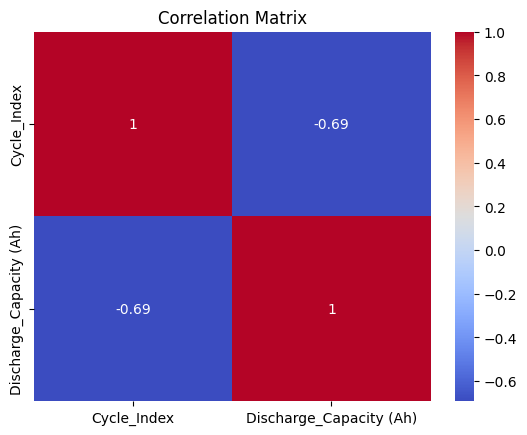

In [ ]:
# Correlation matrix to understand feature relationships
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


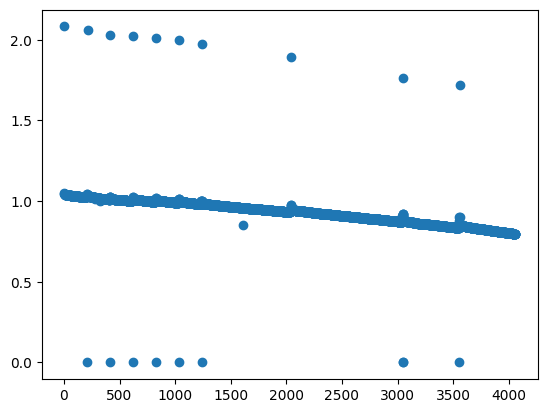

In [ ]:
# Preprocessing: Selecting features and target variable
X = df['Cycle_Index']
y = df['Discharge_Capacity (Ah)']

plt.scatter(X, y)
plt.show()


**DETECTING AND REMOVING OUTLIERS**

In [ ]:
#Detecting outliers
outliers = df[(df['Discharge_Capacity (Ah)'] < 0.5) | (df['Discharge_Capacity (Ah)'] > 1.5)]
print(outliers)

      Cycle_Index  Discharge_Capacity (Ah)
1               4                    2.082
176           207                    0.000
180           212                    2.063
369           414                    0.000
373           418                    2.027
561           620                    0.000
565           624                    2.023
758           826                    0.000
762           830                    2.011
941          1032                    0.000
945          1036                    1.996
1128         1238                    0.000
1132         1242                    1.972
1845         2045                    1.894
2751         3047                    0.000
2752         3048                    0.000
2756         3052                    1.765
3202         3555                    0.000
3205         3559                    1.722


In [ ]:
#removing outliers
df2 = df[(df['Discharge_Capacity (Ah)'] > 0.5) & (df['Discharge_Capacity (Ah)'] < 1.5)]
df2

,Cycle_Index,Discharge_Capacity (Ah)
0,3,1.050
2,5,1.041
3,6,1.041
4,7,1.041
5,8,1.041
...,...,...
3647,4054,0.798
3648,4055,0.797
3649,4056,0.797
3650,4057,0.797


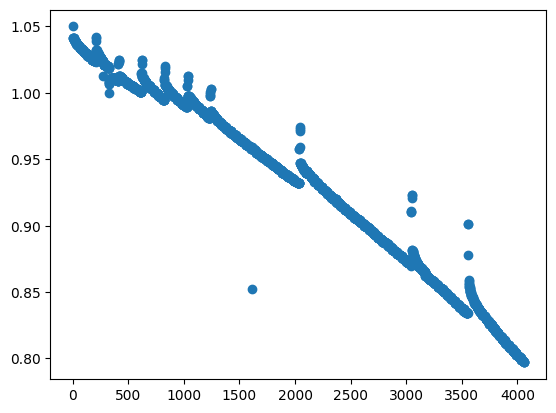

In [ ]:
X2 = df2['Cycle_Index']
#X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition']]
y2 = df2['Discharge_Capacity (Ah)']

plt.scatter(X2, y2)
plt.show()

In [ ]:
df2.drop(1461, inplace=True)
df_cleaned = df2.copy()
df2 = df2.reset_index()
#df2

<ipython-input-29-7c85b1558afb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(1461, inplace=True)


In [ ]:
X3 = df2[['Cycle_Index']]
y3 = df2['Discharge_Capacity (Ah)']

plt.scatter(X3, y3)
plt.show()

**TRAINING MODEL**

In [ ]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [ ]:
# Building the Linear Regression Model
model = LinearRegression()

# Fitting the model on the training data
model.fit(X_train, y_train)

In [ ]:
# Model Evaluation
y_pred = model.predict(X_test)

# Mean Squared Error and R-squared for model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

**FINDING ACTUAL USEFUL LIFE**

In [ ]:
df2['SOH'] = df2['Discharge_Capacity (Ah)']/df2.loc[0,'Discharge_Capacity (Ah)']
df2

index = 0
while index < len(df2) and df2.loc[index, 'SOH'] >= 0.8:
    index = index + 1

if index < len(df2):
    print(df2.loc[index, 'Cycle_Index'])
else:
    print("No row with SOH >= 0.8 found")

actual_useful_life = df2.loc[index, 'Cycle_Index']

**CREATING FUNCTION FOR PREDICTING SOH**

In [ ]:
#SOH = current capacity/initial capacity
def Predict_SOH(dataframe):
  dataframe['Discharge_Capacity (Ah)'] = model.predict(dataframe[['Cycle_Index']])
  dataframe['SOH'] = dataframe['Discharge_Capacity (Ah)']/dataframe.loc[0,'Discharge_Capacity (Ah)']
  return dataframe


#Predict_SOH(df2)

In [ ]:
df3 = df_cleaned.copy()

**PREDICTING USEFUL LIFE FOR GIVEN CYCLE**

In [ ]:
df_pred = Predict_SOH(df_cleaned)
df_predicted = df_pred.reset_index()

index = 0
while index < len(df_predicted) and df_predicted.loc[index, 'SOH'] >= 0.8:
    index = index + 1

if index < len(df_predicted):
    print(df_predicted.loc[index, 'Cycle_Index'])
else:
    print("No row with SOH >= 0.8 found")


# index = df2.
total_predicted_useful_life = df_predicted.loc[index, 'Cycle_Index']
print(total_predicted_useful_life)


cycles = [[500],[1000],[2000],[3000],[3500]]
predicted_RUL = total_predicted_useful_life - cycles
print(predicted_RUL)
actual_RUL = actual_useful_life - cycles
print(actual_RUL)
predicted = model.predict(cycles)

predicted

**PLOTTING GRAPH FOR ACTUAL AND PREDICTED USEFUL LIFE**

In [ ]:
plt.plot(cycles, actual_RUL, label='Actual RUL')
plt.plot(cycles, predicted_RUL, '-.', label='Predicted RUL')

plt.xlabel("Cycles_given")
plt.ylabel("RUL")
plt.title('Actual _VS_Predicted')
plt.legend()
plt.show()

**FUNCTION TO EVALUATE THE PERFORMANCE OF THE MODEL**

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

df4 = df2.reset_index()
def Estimate_error(dataframe):
  y_test = dataframe['Discharge_Capacity (Ah)']
  y_pred = Predict_SOH(dataframe)['Discharge_Capacity (Ah)']
  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  return (rmse, mae)

Estimate_error(df4)